In [1]:
import socket
import numpy as np
import pandas as pd
import platform
import logging
import cpuinfo
import matplotlib.pyplot as plt
import multiprocessing
import os
import datetime

import common



In [5]:
def get_CPU_data(cpu_name):
    if(cpu_name == "AMD Ryzen 7 3700X 8-Core Processor"):
        return {
            "cpu_price": 300.0,
            "cpu_power": 65.0,
            "n_threads": 16,
            "cpu_short_name": "Ryzen7_3700X"
        }
    
    if(cpu_name == "Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz"): 
        return {
            "cpu_price": 3290.0,
            "cpu_power": 150.0,
            "n_threads": 40,
            "cpu_short_name": "Xeon_6248"
        }

    if(cpu_name == "AMD Ryzen 7 3800X 8-Core Processor"):
        return {
            "cpu_price": 300.0,
            "cpu_power": 105,
            "n_threads": 16,
            "cpu_short_name": "Ryzen7_3800X"
        }
        
    else: 
        logging.warning(f"Unknown CPU {cpu_name}")
        return {}


def get_GPU_data(gpu_name):
    if(gpu_name == "NVIDIA GeForce GTX 970"):
        return {
            "gpu_price": 260.0,
            "gpu_power": 500.0,
            "gpu_grid_size": 256,
            "gpu_block_size": 256,
            "gpu_short_name": "GTX_970"
        }

    if(gpu_name == "NVIDIA GeForce RTX 3070"):
        return {
            "gpu_price": 1000,
            "gpu_power": 220,
            "gpu_grid_size": 256,
            "gpu_block_size": 256,
            "gpu_short_name": "RTX_3070"
        }
    if(gpu_name == "Tesla T4"):
        return {
            "gpu_price": 2500.0,
            "gpu_power": 70.0,
            "gpu_grid_size": 256,
            "gpu_block_size": 256,
            "gpu_short_name": "Tesla_T4"
        }

    else: 
        logging.warning(f"Unknown GPU {gpu_name}")
        return {}   
    

def is_cluster():
    if(multiprocessing.cpu_count() > 20): return True
    else: return False


def get_system_information():
    cpu_name = cpuinfo.get_cpu_info()["brand_raw"]
    gpu_name = os.popen("nvidia-smi --query-gpu=name --format=csv").read().split("\n")[1]

    data = {
        "host_name" : socket.gethostname(),
        "cpu_name": cpu_name,
        "gpu_name": gpu_name
    }

    data.update(get_CPU_data(cpu_name))
    data.update(get_GPU_data(gpu_name))
    return data



sys_info = get_system_information()

if(is_cluster()):
    # Cluster
    args = {
        "p_rays_start": 6,
        "p_rays_end": 20,
        "n_bench": 128,
    }
else:
    # Home PC
    args = {
       "p_rays_start": 6,
       "p_rays_end": 26,
       "n_bench": 128
    }

args.update(sys_info)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
outfile = common.globals["paths"]['out_dir'] + f"{timestamp}_{args['cpu_short_name']}_{args['gpu_short_name']}.csv" 


In [24]:
df = common.run_benchmark(
    args=f"--ray_offset 0.2 \
    --omp_n_threads {args['n_threads']} \
    --p_rays_start {args['p_rays_start']} \
    --p_rays_end {args['p_rays_end']} \
    --outfile {outfile} \
    --n_bench {args['n_bench']}",
    print_output=False)

'2022-03-31 23-28-25_Ryzen7_3700X_GTX_970.csv'

In [37]:
df = common.load_df(outfile)
df.tail(10)

time         Rps   Rps/Eur    Rps/W  n_blocks  \
n_rays kernel                                                           
32761  OpenVDB      0.007242   4523820.0  11309.50  30158.8       1.0   
54756  NanoVDB_CPU  0.010626   5153000.0  12882.50  34353.3       1.0   
       NanoVDB_GPU  0.006162   8886030.0  22215.10  17772.1     256.0   
       OpenVDB      0.017688   3095660.0   7739.14  20637.7       1.0   
92416  NanoVDB_CPU  0.013177   7013550.0  17533.90  46757.0       1.0   
       NanoVDB_GPU  0.006897  13398600.0  33496.50  26797.2     256.0   
       OpenVDB      0.024246   3811660.0   9529.15  25411.1       1.0   
155236 NanoVDB_CPU  0.024974   6215970.0  15539.90  41439.8       1.0   
       NanoVDB_GPU  0.012108  12821100.0  32052.80  25642.3     256.0   
       OpenVDB      0.036290   4277650.0  10694.10  28517.7       1.0   

                    n_threads  
n_rays kernel                  
32761  OpenVDB            1.0  
54756  NanoVDB_CPU        1.0  
       NanoVDB_GPU      256.0  
       OpenVDB            1.0  
92416  NanoVDB_CPU        1.0  
       NanoVDB_GPU      256.0  
       OpenVDB            1.0  
155236 NanoVDB_CPU        1.0  
       NanoVDB_GPU      256.0  
       OpenVDB            1.0

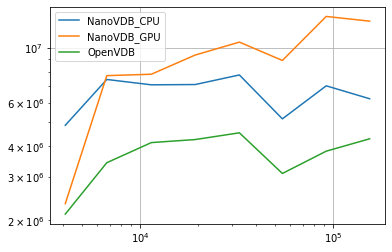

In [38]:
kernels = df.reset_index()["kernel"].unique()

for kernel in kernels:
    plt.plot(df["Rps"].loc[:,kernel], label=kernel)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()

In [37]:
kernels = df.reset_index()["kernel"].unique()

array(['NanoVDB_CPU', 'NanoVDB_GPU', 'OpenVDB'], dtype=object)